# Making colour images from data layers
Gilles Ferrand<br>
2020-01-16

This notebook shows how to make colour images by combining data layers, using either RGB channels or arbitrary blending.<br>
Note that we do not consider here the preliminary steps of image registration and data stretching (we will only allow for a linear weight), nor the final steps of global adjustments, cosmetic edits, and cropping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plt_show(array,ax=None,cmap='gray'):
    if ax==None: ax=plt.gca()
    ax.imshow(array,aspect='equal',cmap=cmap)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

mock data: random Gaussian clumps

In [3]:
import mock
reload(mock)

<module 'mock' from 'mock.pyc'>

In [4]:
n_size = 256
layers = []
for j in range(6):
    print "realization #",j
    layers.append([np.zeros((n_size,n_size))])
    for i in np.linspace(0,2,6):
        clumps = mock.Gaussian_clumps(nx=n_size, ny=n_size, n_clumps=int(10**i), sigma=[10**(-i)])
        layers[j].append(clumps)
        layers[j][0] += clumps

realization # 0
realization # 1
realization # 2
realization # 3
realization # 4
realization # 5


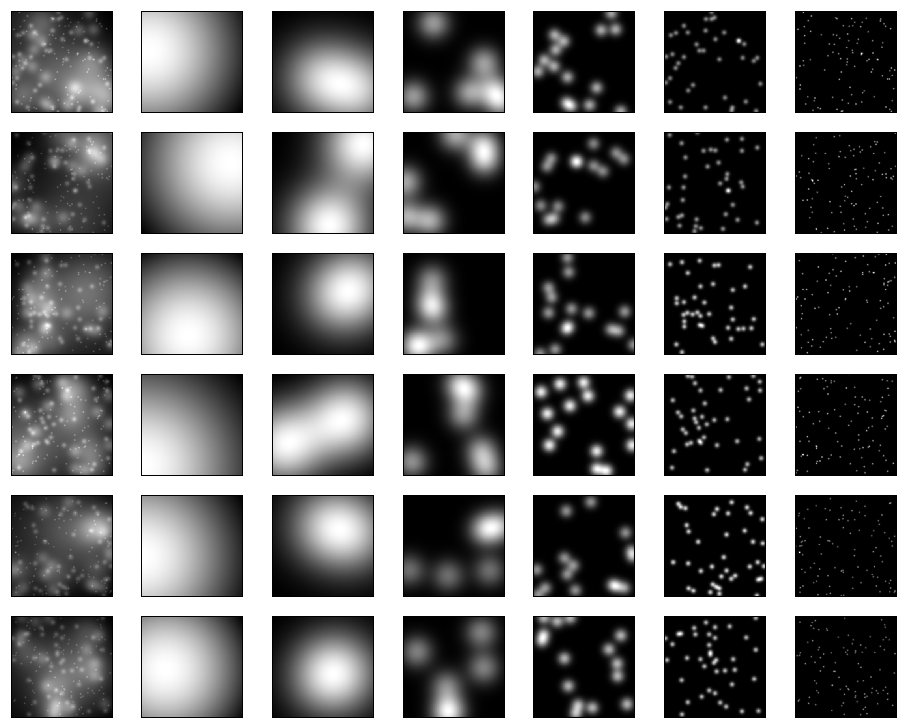

In [5]:
fig, ax = plt.subplots(len(layers),len(layers[0]), figsize=(16,16*len(layers)/len(layers[0])))
for j in range(len(layers)):
    for i in range(len(layers[j])): 
        plt_show(layers[j][i],ax[j,i])

Each row is an independent, random realization.<br>
Columns show clumps at different scales, the first one being the sum.

In [6]:
import combine
reload(combine)

<module 'combine' from 'combine.pyc'>

## The naive way: RGB channels

This technique is straightforward, but works with only exactly 3 layers, and hue choices are restricted to the 3 RGB primaries.

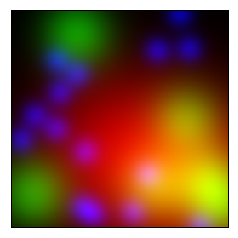

In [7]:
# first set, 3 scales
image = combine.RGB(layers[0][2:5])
plt_show(image)

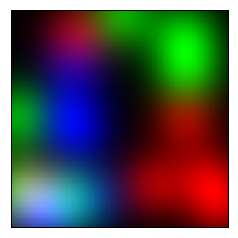

In [8]:
# medium scale, 3 sets
image = combine.RGB(zip(*layers)[3][:3])
plt_show(image)

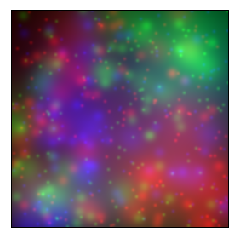

In [9]:
# all scales, 3 sets
image = combine.RGB(zip(*layers)[0][:3])
plt_show(image)

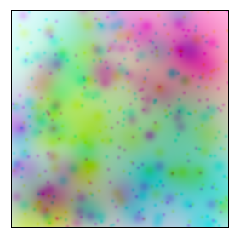

In [10]:
# inverted (not the same as blending the secondary colours)
for i in range(3): image[:,:,i] = 1-image[:,:,i]
plt_show(image)

## The advanced way: blending layers

This techniques works with any number of layers, and allows one to select any hue per layer. <br>It requires defining a blending mode, the optimal mode being known as "screen".

In [11]:
H = [0, 60, 120, 180, 240, 300]
S = [100]*len(H)
V = [100]*len(H)

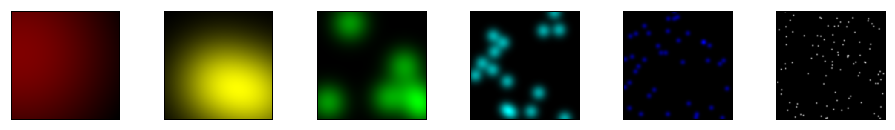

In [12]:
# first set, 6 scales
S[-1] = 0 # neutral "stars"
V[0] = 50 # darker bkg "cloud"
colourized_layers = []
for i in range(6):
    colourized_layers.append(combine.colourize(layers[0][1+i], H[i], S[i], V[i]))

fig, ax = plt.subplots(1,len(colourized_layers), figsize=(16,16/len(colourized_layers)))
for i in range(len(colourized_layers)): plt_show(colourized_layers[i],ax[i])

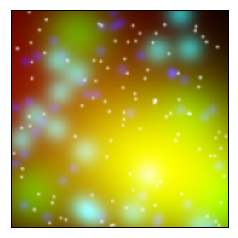

In [13]:
image = combine.blend(colourized_layers, combine.Screen)
plt_show(image)

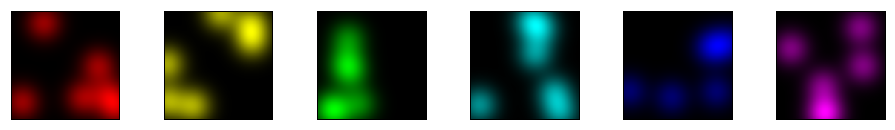

In [14]:
# medium scale, 6 sets
S = [100]*len(H)
V = [100]*len(H)
colourized_layers = []
for i in range(6):
    colourized_layers.append(combine.colourize(zip(*layers)[3][i], H[i], S[i], V[i]))

fig, ax = plt.subplots(1,len(colourized_layers), figsize=(16,16/len(colourized_layers)))
for i in range(len(colourized_layers)): plt_show(colourized_layers[i],ax[i])

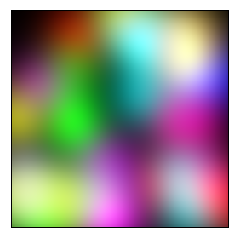

In [15]:
image = combine.blend(colourized_layers, combine.Screen)
plt_show(image)

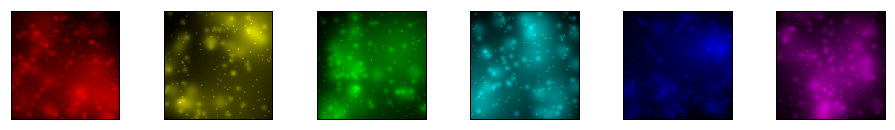

In [16]:
# all scales, 6 sets
S = [100]*len(H)
V = [100]*len(H)
colourized_layers = []
for i in range(6):
    colourized_layers.append(combine.colourize(zip(*layers)[0][i], H[i], S[i], V[i]))

fig, ax = plt.subplots(1,len(colourized_layers), figsize=(16,16/len(colourized_layers)))
for i in range(len(colourized_layers)): plt_show(colourized_layers[i],ax[i])

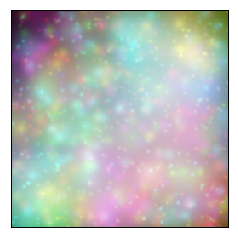

In [17]:
image = combine.blend(colourized_layers, combine.Screen)
plt_show(image)

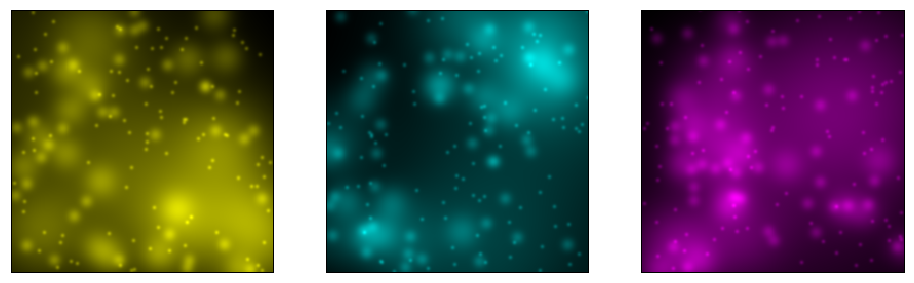

In [18]:
# all scales, 3 sets
H = [60, 180, 300]
colourized_layers = []
for i in range(3):
    colourized_layers.append(combine.colourize(zip(*layers)[0][i], H[i], S[i], V[i]))

fig, ax = plt.subplots(1,len(colourized_layers), figsize=(16,16/len(colourized_layers)))
for i in range(len(colourized_layers)): plt_show(colourized_layers[i],ax[i])

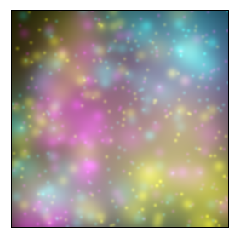

In [19]:
image = combine.blend(colourized_layers, combine.Screen)
plt_show(image)